<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone - Resumes and Job Ads Recommender

# Problem Statement

HR practitioners and/or hiring managers could have been spending too much time trying to sieve through many resumes for shortlisting suitable candidates whom they can contact for interview.
As a job seeker, we may also find ourselves spending so much times looking through plentiful job advertisements which may not be relevant to us.
Wouldn't it be nice if pre-selection can be done which will effectively save time for all of us?

We will be using Natural Language Processing and Recommender System to group similar job seekers / job advertisements.
Success will be evaluated by the (TBD on model) to match the job the grouped job seekers to the most suitable job advertisements and vice versa.

# Executive Summary

We scrape the website spiderjob.com for resumes. In view that api key is not available, we used BeautifulSoup and regex to get the desired information. As we encounter roadblock on the time connection timeout despite introducing bot agent, we limit the job categories to Accounting and Information Technology for this capstone. 
For the job ads, we based it on existing dataset that is available on Kaggle which was used for predicting fake job posting since the features in this dataset has 80% simiarity to the resumes dataset.

As we were cleaning the resumes dataset, we at the same made decision which features will be important for us to have and which are the one to drop. In view that job title, objective, experience and skills are free texts that hold meaningful words for our analysis, we create a new feature and combine all where we then split the text into words, return them to their root form and also remove the stop words. These are performed for the job ads dataset.

TBC.....


### Contents:
- [Data Cleaning & EDA - Job Ads](#Data-Cleaning-&-EDA---Job-Ads)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict

%matplotlib inline

C:\Users\eukar\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Cleaning & EDA - Job Ads

There are 3 datasets altogether (Accounting resumes, IT resumes and job postings).\
We will first combined both Accounting and IT datasets for cleaning, followed by job postings.\
We will have to standardize the headers, selection of data between these datasets.

In [2]:
# Import job ads dataset
jobs = pd.read_csv('.\datasets\job_posting.csv', encoding="ISO-8859-1")

In [3]:
# Check out the shape and info of dataset
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10427 entries, 0 to 10426
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               10427 non-null  int64 
 1   title                10427 non-null  object
 2   state                10427 non-null  object
 3   state_name           10427 non-null  object
 4   department           2946 non-null   object
 5   salary_range         1500 non-null   object
 6   company_profile      8507 non-null   object
 7   description          10426 non-null  object
 8   requirement          8719 non-null   object
 9   benefits             5889 non-null   object
 10  telecommuting        10427 non-null  int64 
 11  has_company_logo     10427 non-null  int64 
 12  has_questions        10427 non-null  int64 
 13  employment_type      8664 non-null   object
 14  required_experience  6280 non-null   object
 15  required_education   6081 non-null   object
 16  indu

In [4]:
# Check out top 5 rows of the dataset
jobs.head()

,job_id,title,state,state_name,department,salary_range,company_profile,description,requirement,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
0,1,Marketing Intern,NY,New York,Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing
1,2,Commissioning Machinery Assistant (CMA),IA,Iowa,NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN
2,3,Account Executive - Washington DC,DC,WashingtonDC,Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI â Environmental Systems Re...,"EDUCATION:Â Bachelorâs or Masterâs in GIS,...",Our culture is anything but corporateâwe hav...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales
3,4,Bill Review Manager,FL,Florida,NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider
4,5,Accounting Clerk,MD,Maryland,NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN


In [5]:
# Check out the function
print('Number of unique function: ', len(set(jobs.function)))
set(jobs.function)

Number of unique function:  38


{'Accounting',
 'Administrative',
 'Advertising',
 'Art/Creative',
 'Business Analyst',
 'Business Development',
 'Consulting',
 'Customer Service',
 'Data Analyst',
 'Design',
 'Distribution',
 'Education',
 'Engineering',
 'Finance',
 'Financial Analyst',
 'General Business',
 'Health Care Provider',
 'Human Resources',
 'Information Technology',
 'Legal',
 'Management',
 'Manufacturing',
 'Marketing',
 'Other',
 'Product Management',
 'Production',
 'Project Management',
 'Public Relations',
 'Purchasing',
 'Quality Assurance',
 'Research',
 'Sales',
 'Science',
 'Strategy/Planning',
 'Supply Chain',
 'Training',
 'Writing/Editing',
 nan}

In [6]:
# Choose Accounting and Information Technology to align with the industry in resumes
jobs = jobs[(jobs['function']=='Accounting') | (jobs['function']=='Information Technology')].reset_index(drop=True)
print(jobs.shape)
jobs.head()

(792, 18)


,job_id,title,state,state_name,department,salary_range,company_profile,description,requirement,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
0,9,ASP.net Developer Job opportunity at United St...,NJ,New Jersey,NaN,100000-120000,NaN,DeveloperJob Location :United States-New Jerse...,#URL_86fd830a95a64e2b30ceed829e63fd384c289e4f...,Benefits - FullBonus Eligible - YesInterview T...,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology
1,10,"Applications Developer, Digital",CT,Connecticut,NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...","The Applications Developer, Digital will devel...",s:4 â 5 yearsâ experience in developing an...,NaN,0,1,0,Full-time,Associate,Bachelor's Degree,Management Consulting,Information Technology
2,38,Technical Project Manager,NY,New York,NaN,NaN,NaN,GBI is a growing company developing several cu...,Must have excellent oral and written communica...,"Experience with CRM, such as SugarCRM.Past emp...",0,0,0,Full-time,Associate,Bachelor's Degree,Financial Services,Information Technology
3,49,Ruby Automation Engineer & Ruby on Rails Engin...,CA,California,IT,NaN,NaN,"# 1Ruby Automation Engineer Menlo Park, CA # ...",Position # 1Ruby Automation EngineerLocation: ...,NaN,0,0,1,Contract,Mid-Senior level,Associate Degree,NaN,Information Technology
4,54,Mid-Senior .NET or Xamarin Developer,GA,Georgia,NaN,75-115,NaN,DataFinch Technologies is the leader in electr...,We are looking for candidates who are generall...,"Health, Vision, Dental, FSA, HSA, 401(k)Privat...",0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Information Technology


### Data Dictionary

In [7]:
%%html
<style>
table {float:left}
</style>

| Data Dictionary for job ads 	|                                                                                          |
|:-----------------------------	|:-----------------------------------------------------------------------------------------|
| job_id                      	| job ads id                                                                               |
| title                       	| job title of the position                                                                |
| state                       	| postal abbreviation of the state name                                                    |
| state_name                  	| name of the US state                                                                     |
| department                  	| department name where the position will be joining                                       |
| salary_range                	| salary range of the position                                                             |
| company_profile             	| brief company description                                                                |
| description                 	| details description of the job ad                                                        |
| requirement                 	| enlisted requirements for the job opening                                                |
| benefits                    	| enlisted offered benefits by the employer                                                |
| telecommuting               	| true (1) for telecommuting positions i.e. work from home, use of email, etc              |
| has_company_logo            	| true if company logo is present                                                          |
| has_questions               	| true if screening questions are present                                                  |
| employment_type             	| employment type e.g. full time/part time permanent, contract, etc                        |
| required_experience         	| job level of the position e.g. Executive (President, VP, CEO), new grad/entry level, etc |
| required_education          	| education level e.g. bachelors, masters, etc                                             |
| industry                    	| job industry of the position                                                             |
| function                    	| job function of the position i.e. Accounting and Information Technology                                                             |

### Let's look at each feature, perform data cleaning so that it can help us to decide which features will be useful for modeling.

In [8]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               792 non-null    int64 
 1   title                792 non-null    object
 2   state                792 non-null    object
 3   state_name           792 non-null    object
 4   department           297 non-null    object
 5   salary_range         221 non-null    object
 6   company_profile      562 non-null    object
 7   description          791 non-null    object
 8   requirement          752 non-null    object
 9   benefits             468 non-null    object
 10  telecommuting        792 non-null    int64 
 11  has_company_logo     792 non-null    int64 
 12  has_questions        792 non-null    int64 
 13  employment_type      788 non-null    object
 14  required_experience  792 non-null    object
 15  required_education   683 non-null    object
 16  industry

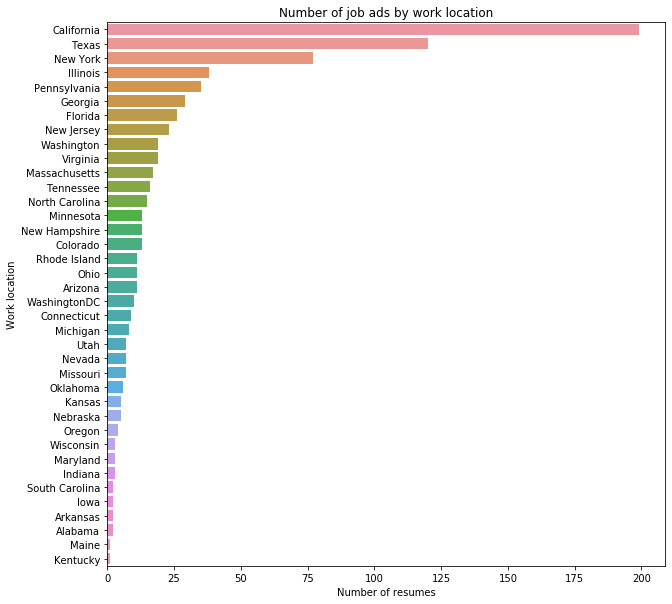

In [9]:
# Plotting the number of job ads by work locations
plt.figure(figsize=(10,10))
work_loc = jobs.groupby(jobs['state_name'], as_index=False)['job_id'].count().sort_values(by='job_id',ascending=False)
sns.barplot(x=work_loc.job_id, y='state_name', data=work_loc, orient='h')
plt.title('Number of job ads by work location')
plt.xlabel('Number of resumes')
plt.ylabel('Work location');

Top 3 locations with the highest job ads and job seekers are California, Texas and New York.

In [10]:
# Check out department
print('% of isnull value in department: {}% '.format(round(jobs['department'].isnull().sum()/jobs['job_id'].count()*100)))

% of isnull value in department: 62.0% 


In view that there isn't a column for job seeker to indicate their desired work department, we will drop this feature in the job ads for modelling.

In [11]:
# Check out salary_range
print('% of isnull value in salary_range: {}% '.format(round(jobs['salary_range'].isnull().sum()/jobs['job_id'].count()*100)))
set(jobs.salary_range)

% of isnull value in salary_range: 72.0% 


{'0-0',
 '0-110406',
 '0-24000',
 '0-95000',
 '10000-120000',
 '100000-117000',
 '100000-120000',
 '100000-125000',
 '100000-130000',
 '100000-150000',
 '100000-160000',
 '100000-170000',
 '110000-120000',
 '110000-125000',
 '110000-140000',
 '115-120',
 '115000-130000',
 '120-160',
 '120000-125000',
 '120000-130000',
 '120000-135000',
 '120000-15000000',
 '12500-15000',
 '125000-135000',
 '13-15',
 '130000-150000',
 '130000-160000',
 '130000-170000',
 '140-160',
 '140000-160000',
 '15-17',
 '150000-16500000',
 '15500-16500',
 '1600-1700',
 '18000-25000',
 '20-25',
 '20000-25000',
 '20000-30000',
 '21-31',
 '24000-28000',
 '25000-30000',
 '25000-45000',
 '26000-28000',
 '30000-33000',
 '30000-35000',
 '30000-37500',
 '30000-40000',
 '30000-45000',
 '30000-50000',
 '32500-37500',
 '35-45',
 '35-60',
 '35000-35000',
 '35000-40000',
 '35000-42000',
 '35000-45000',
 '35000-50000',
 '35000-55000',
 '35000-65000',
 '35000-70000',
 '38000-48000',
 '40000-45000',
 '40000-50000',
 '40000-55000'

We observed the same issue with have in `salary_range` with `desired wage` in the resumes.\
Inconsistency in term of unit and high % of missing value, thus, we will drop this feature as well.

In [12]:
# Check out company_profile
jobs['company_profile'][jobs['company_profile'].notnull()]

1      Novitex Enterprise Solutions, formerly Pitney ...
5      Yazamo is a rapidly growing digital lifecycle ...
10     Shapeways is the leading 3D printing marketpla...
11     Why CSD?CSD is not only a great place to work,...
16     CAKE is a marketing technology company providi...
                             ...                        
777    We specialize in helping local companies grow ...
779    Visual BI is one of the leading and fastest gr...
780    Meet cove, a network of neighborhood productiv...
789    Outstanding Member Service Starts With Outstan...
791    WebLinc is the e-commerce platform and service...
Name: company_profile, Length: 562, dtype: object

As it is about company description and it doesn't seem to contain words on skill, experience, etc, we will drop this feature for modelling as well.

In [13]:
# Check out description, see full description for one entry
jobs['description'][jobs['description'].notnull()][1]

'The Applications Developer, Digital will develop or participate in the development, support or migration of the web and intranet applications, along with other business applications that may be cloud or locally hosted.Â\xa0Our goal to make sure our applications are state of the art, available and content-rich. We also thrive to make sure all our users are satisfied and that all support requests are answered-to in timely manner.Key Responsibilities:PHP and (C# and VB) development per project needs.Design, create and program MySQL and SQL Server databases per project needs.Triage and resolve tickets for supported systems and applicationsProvide troubleshooting expertise for proprietary applications in Production and Support environmentsDocument new and update solutions and process documentationFollow established procedures for managing risk when updating production systemsCreate and update process automationMigrate applications between different environmentsDeploy new applicationsManage

In [14]:
# Check out requirement, see full requirement for one entry
jobs['requirement'][jobs['requirement'].notnull()][1]

's:4 â\x80\x93 5 yearsâ\x80\x99 experience in developing and deploying web applications.Solid understanding of SDLC.Knowledge of PHP, MySQL, SQL server and .netKnowledge in setting up application development environments (Internet and intranet)Knowledge of web application deployment and server configuration methodologiesKnowledge of content management systems and web analyticsAbility to troubleshoot applications and user issuesAdditional Preferred Experience:Knowledge of office 365 applicationsKnowledge of SharePoint administrationSalesforce administration and integrationForward-thinking business development-focused mentality and work style.Good customer service orientation and attitude.Effective communication , both verbal and written.Comfortable working with business support tools: MS Excel, MS Word, MS Outlook, MS PowerPoint and Visio.'

Both `description` and `requirement` contain keywords on skills, requirement, etc, which we can consider to combine as a new feature.

`telecommuting`, `has_company_logo` and `has_questions` are not relevant for the purpose of this analysis, thus, we will drop these features too.

In [15]:
# Check out the selection and frequencies of each selection of employment_type
print('Sum of count: ', jobs.groupby('employment_type')['employment_type'].count().sum())
jobs.groupby('employment_type')['employment_type'].count()

Sum of count:  788


employment_type
Contract      147
Full-time     618
Internship      8
Other           2
Part-time      13
Name: employment_type, dtype: int64

In [16]:
# Check out content of filter by employment_type isnull
emp_isnull = jobs[jobs['employment_type'].isnull()]
emp_isnull

,job_id,title,state,state_name,department,salary_range,company_profile,description,requirement,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
167,2463,Systems Engineer,NY,New York,IT,NaN,MAP Digital: MetaMeetings is a digital events ...,MAP Digital: MetaMeetingsTM is seeking an expe...,4+ years experience with Windows Desktop/Serve...,NaN,0,1,1,NaN,Mid-Senior level,NaN,Events Services,Information Technology
176,2611,Bookkeeper FT/PT,NY,New York,NaN,NaN,NaN,"GPN, an optometric consulting firm, is seeking...",Tasks and AccountabilitiesÂ Post daily auto pa...,NaN,0,0,0,NaN,Associate,Certification,"Health, Wellness and Fitness",Accounting
676,8557,Senior Web Developer,PA,Pennsylvania,Web Development,NaN,WebLinc is the e-commerce platform and service...,The Senior WebÂ Developer will work with tech ...,s:3+ years of relevant experienceAny coding la...,Health &amp; WellnessMedical planPrescription ...,0,1,1,NaN,Associate,NaN,Internet,Information Technology
685,8651,UI Developer For Rails App,FL,Florida,NaN,NaN,Hello Show is transforming the way real estate...,Hello Show is transforming the way real estate...,"Insane, pixel-perfect attention to detailsExpe...","Our team is 100% remote, and you will have the...",1,1,1,NaN,Mid-Senior level,NaN,Computer Software,Information Technology


In [17]:
# Checking out the description, requirement to see if there's information on the employment_type
emp_isnull.requirement[167]

'4+ years experience with Windows Desktop/Server and Linux(Ubuntu) Engineering and Support.Strong experience working in a LAMP environment.Some basic experience with Cisco networking devices.Fundamental understanding of Internet services and protocols including DNS, TCP/IP, VPN, SMTP,Â\xa0IMAP, etc.You must be able to explain how services/protocols work according to RFC standards, if you canâ\x80\x99t thenÂ\xa0please donâ\x80\x99t apply.Strong experience with design and architecture of systems.Strong experience with designing and implementing backups and disaster recovery plans.Strong written and verbal communication skill.Ability to collaborate with other teams.Must be able to lift heavy objects, such as servers/printers/routers, and move them 10 feet.Must be able to travel via airplane due to the nature of our clientâ\x80\x99s live event needs.'

In [18]:
# Checking out the description, requirement to see if there's information on the employment_type
emp_isnull.description[176]

'GPN, an optometric consulting firm, is seeking a full-charge Bookkeeper full-time or part-time.To apply for this position, please submit your application via this link:Â\xa0#URL_dc6a4e8df8c88cf7bb611c27fadf835b2ea6d40cec837463b39bb6ba9bca8852#?i=MTkzÂ\xa0and select the Bookkeeper (Farmingdale, New York) position from the Job Opening drop-down menu.'

In [19]:
# Checking out the description, requirement to see if there's information on the employment_type
emp_isnull.description[676]

"The Senior WebÂ\xa0Developer will work with tech leads and designers to make some of the best ecommerce and content sites on the web. You will report to a Tech Lead who will help you through the rough spots, but you'll have enough rope to do the job properly. Must have the ability to communicate well and thrive in a team environment.Â\xa0Technologies in-house:Â\xa0Ruby on Rails, ColdFusion, .NET, Front-end technologies (HTML, CSS, JS, JQ, etc.), Mobile Technologies (iOS and Android)."

In [20]:
# Checking out the description, requirement to see if there's information on the employment_type
emp_isnull.requirement[685]

'Insane, pixel-perfect attention to detailsExpert with HTML5 and CSS3Expert building responsive HTML/CSS web applicationsMust have access to a Mac with SketchComfortable working within Rails applicationExperience writing Ruby / Javascript is a major plusLoves collaborating on designLoves user experienceYou will be asked to provide a minimum of 2 references.'

In view that there isn't specific indication on the type of employment, we will reclassify these under `other`.

In [21]:
# Change content to lower case
jobs['employment_type'] = jobs['employment_type'].str.lower()

# Rename NaN to other
jobs['employment_type'] = jobs['employment_type'].replace(np.nan, 'other')

In [22]:
# Final check on the count and sum of employment_type
print('Sum of count: ', jobs.groupby('employment_type')['employment_type'].count().sum())
jobs.groupby('employment_type')['employment_type'].count()

Sum of count:  792


employment_type
contract      147
full-time     618
internship      8
other           6
part-time      13
Name: employment_type, dtype: int64

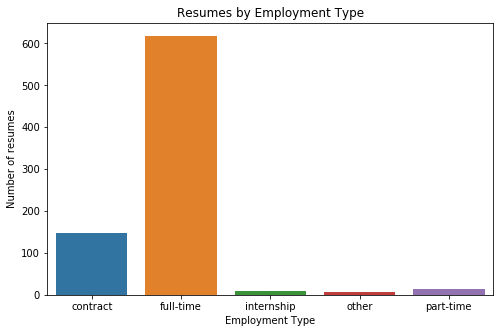

In [23]:
# Plot the employment_type to see the distribution
plt.figure(figsize=(8,5))
e_type = jobs.groupby(jobs['employment_type'], as_index=False)['job_id'].count().sort_values(by='employment_type')
sns.barplot(x='employment_type', y=e_type.job_id, data=e_type)
plt.title('Resumes by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Number of resumes');

Most of the job ads are hiring for full-time positions.

In [24]:
# Check out the selection and frequencies of each selection of required_experience
print('Sum of count: ', jobs.groupby('required_experience')['required_experience'].count().sum())
jobs.groupby('required_experience')['required_experience'].count()

Sum of count:  792


required_experience
Associate           257
Director             24
Entry level          55
Executive             8
Internship            7
Mid-Senior level    441
Name: required_experience, dtype: int64

We need to align the definition of the required_experience with the selection in resumes namely:\
`associate`\
`entry_level`\
`executive`\
`internship`\
`mid-senior`

In [25]:
# Change content to lower case
jobs['required_experience'] = jobs['required_experience'].str.lower()

# Rename director to mid-senior level
jobs['required_experience'] = jobs['required_experience'].replace('director', 'mid-senior level')

# Rename entry level to entry_level
jobs['required_experience'] = jobs['required_experience'].replace('entry level', 'entry_level')

# Rename mid-senior level to mid_senior
jobs['required_experience'] = jobs['required_experience'].replace('mid-senior level', 'mid_senior')

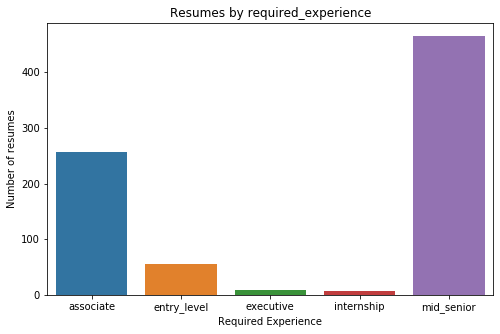

In [26]:
# Plot the revised required_experience to see the distribution
plt.figure(figsize=(8,5))
r_exp = jobs.groupby(jobs['required_experience'], as_index=False)['job_id'].count().sort_values(by='required_experience')
sns.barplot(x='required_experience', y=r_exp.job_id, data=r_exp)
plt.title('Resumes by required_experience')
plt.xlabel('Required Experience')
plt.ylabel('Number of resumes');

The majority of the job ads are looking for associate and mid_senior level which are not surprising as we are only covering 2 specialization i.e. `Accounting` and `Information Technology`.
Thus we can expect a higher percentage of PMET* `Professional, Managers, Executives and Technicians`\
And this are in line with the job seekers.

In [27]:
# Check out the selection and frequencies of each selection of required_education
print('Sum of count: ', jobs.groupby('required_education')['required_education'].count().sum())
jobs.groupby('required_education')['required_education'].count()

Sum of count:  683


required_education
Associate Degree                      69
Bachelor's Degree                    459
Certification                         19
High School or equivalent             22
Master's Degree                       19
Some College Coursework Completed      6
Unspecified                           89
Name: required_education, dtype: int64

We need to align the definition of the required_education with the selection in resumes namely:\
`bachelors`\
`certificate`\
`college`\
`degree`\
`high_school`\
`masters`\
`unspecified`

In [28]:
# Check out isnull
jobs['required_education'].isnull().sum()

109

There are 109 null values. As there is an option for unspecified, we will impute these to unspecified.

In [29]:
# Change content to lower case
jobs['required_education'] = jobs['required_education'].str.lower()

# Rename associate degree to degree
jobs['required_education'] = jobs['required_education'].replace('associate degree', 'degree')

# Rename associate bachelor's degree to degree
jobs['required_education'] = jobs['required_education'].replace("bachelor's degree", 'bachelors')

# Rename certification to certificate
jobs['required_education'] = jobs['required_education'].replace('certification', 'certificate')

# Rename high school or equivalent to high_school
jobs['required_education'] = jobs['required_education'].replace('high school or equivalent', 'high_school')

# Rename master's degree to masters
jobs['required_education'] = jobs['required_education'].replace("master's degree", 'masters')

# Rename some college coursework completed to college
jobs['required_education'] = jobs['required_education'].replace('some college coursework completed', 'college')

# Imput isnull to unspecified
jobs['required_education'] = jobs['required_education'].replace(np.nan, 'unspecified')

# Check the final output
print('Sum of count: ', jobs.groupby('required_education')['required_education'].count().sum())
jobs.groupby('required_education')['required_education'].count()

Sum of count:  792


required_education
bachelors      459
certificate     19
college          6
degree          69
high_school     22
masters         19
unspecified    198
Name: required_education, dtype: int64

Percentage of bachelors is 58% out of the total population.


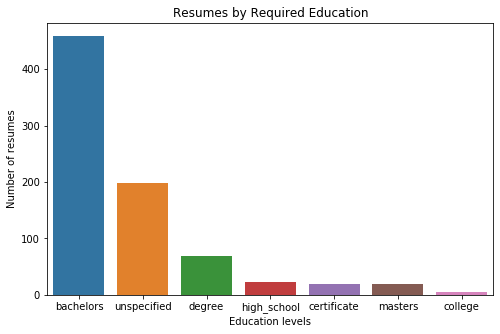

In [30]:
# Plot the revised required education to see the distribution
plt.figure(figsize=(8,5))
req_edu = jobs.groupby(jobs['required_education'], as_index=False)['job_id'].count().sort_values(by='job_id', ascending=False)
sns.barplot(x='required_education', y=req_edu.job_id, data=req_edu)
plt.title('Resumes by Required Education')
plt.xlabel('Education levels')
plt.ylabel('Number of resumes');

print('Percentage of bachelors is {}% out of the total population.'.format(round(459/792*100)))

In [31]:
# Check out industry
print('Count of industry: ',len(set(jobs['industry'])))
set(jobs['industry'])

Count of industry:  64


{'Accounting',
 'Airlines/Aviation',
 'Apparel & Fashion',
 'Automotive',
 'Banking',
 'Biotechnology',
 'Capital Markets',
 'Chemicals',
 'Computer & Network Security',
 'Computer Games',
 'Computer Hardware',
 'Computer Networking',
 'Computer Software',
 'Construction',
 'Consumer Electronics',
 'Consumer Goods',
 'Consumer Services',
 'Defense & Space',
 'Design',
 'E-Learning',
 'Education Management',
 'Electrical/Electronic Manufacturing',
 'Entertainment',
 'Environmental Services',
 'Events Services',
 'Farming',
 'Financial Services',
 'Food & Beverages',
 'Gambling & Casinos',
 'Government Administration',
 'Government Relations',
 'Health, Wellness and Fitness',
 'Hospital & Health Care',
 'Industrial Automation',
 'Information Technology and Services',
 'Insurance',
 'Internet',
 'Law Enforcement',
 'Leisure, Travel & Tourism',
 'Logistics and Supply Chain',
 'Management Consulting',
 'Marketing and Advertising',
 'Mechanical or Industrial Engineering',
 'Media Production'

As this refers to the industry of the company that post the job ads and in the resumes, there isn't an option for job seekers to indicate their preferred industry to work in, we will drop this feature.

In [32]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               792 non-null    int64 
 1   title                792 non-null    object
 2   state                792 non-null    object
 3   state_name           792 non-null    object
 4   department           297 non-null    object
 5   salary_range         221 non-null    object
 6   company_profile      562 non-null    object
 7   description          791 non-null    object
 8   requirement          752 non-null    object
 9   benefits             468 non-null    object
 10  telecommuting        792 non-null    int64 
 11  has_company_logo     792 non-null    int64 
 12  has_questions        792 non-null    int64 
 13  employment_type      792 non-null    object
 14  required_experience  792 non-null    object
 15  required_education   792 non-null    object
 16  industry

In [33]:
# Combine title, description and requirement
jobs['combine_text'] = jobs['title'] + ' ' + jobs['description'].fillna('') + ' ' + jobs['requirement'].fillna('')

# Split the dataframe by function so that we can visualize the words in combine_text
# Creating acct_cleaned dataframe
mask = jobs.mask(jobs.function == 'Information Technology')
acct_cleaned = mask[mask['function'].notnull()]
print('Shape of Accounting function dataframe: ',acct_cleaned.shape)

# Creating it_cleaned dataframe
mask1 = jobs.mask(jobs.function == 'Accounting')
it_cleaned = mask1[mask1['function'].notnull()]
print('Shape of Information Technology function dataframe: ',it_cleaned.shape)

Shape of Accounting function dataframe:  (88, 19)
Shape of Information Technology function dataframe:  (704, 19)


In [34]:
# Check out the top 3 of Accounting to ensure we split the data correctly
acct_cleaned.reset_index(inplace=True)
acct_cleaned.head(3)

,index,job_id,title,state,state_name,department,salary_range,company_profile,description,requirement,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,combine_text
0,10,187.0,Financial Accountant,NY,New York,Finance,NaN,Shapeways is the leading 3D printing marketpla...,"Shapeways is a fast-growing, global startup, w...",A four year degree in Accounting3-5 years of d...,Medical Benefits (Individual medical benefits ...,0.0,1.0,0.0,full-time,associate,bachelors,Consumer Goods,Accounting,Financial Accountant Shapeways is a fast-growi...
1,18,267.0,Accounting Assistant,NV,Nevada,NaN,1600-1700,Crossroads Staffing dedicates a significant am...,Looking for an experienced Accounting Assistan...,Minimum Qualifications Required:2+ years Accou...,$16.00-$17.00/hour,0.0,1.0,0.0,full-time,entry_level,bachelors,Real Estate,Accounting,Accounting Assistant Looking for an experience...
2,19,268.0,Sr. Accountant,PA,Pennsylvania,Accounting,NaN,WebLinc is the e-commerce platform and service...,"WebLinc, a leading provider of eCommerce techn...",B.A. or B.S. in AccountingIntermediate to adva...,Health &amp; WellnessMedical planPrescription ...,0.0,1.0,1.0,full-time,mid_senior,bachelors,Internet,Accounting,"Sr. Accountant WebLinc, a leading provider of ..."


In [35]:
# Check out the top 3 of Information Technology to ensure we split the data correctly
it_cleaned.reset_index(inplace=True)
it_cleaned.head(3)

,index,job_id,title,state,state_name,department,salary_range,company_profile,description,requirement,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,combine_text
0,0,9.0,ASP.net Developer Job opportunity at United St...,NJ,New Jersey,NaN,100000-120000,NaN,DeveloperJob Location :United States-New Jerse...,#URL_86fd830a95a64e2b30ceed829e63fd384c289e4f...,Benefits - FullBonus Eligible - YesInterview T...,0.0,0.0,0.0,full-time,mid_senior,bachelors,Information Technology and Services,Information Technology,ASP.net Developer Job opportunity at United St...
1,1,10.0,"Applications Developer, Digital",CT,Connecticut,NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...","The Applications Developer, Digital will devel...",s:4 â 5 yearsâ experience in developing an...,NaN,0.0,1.0,0.0,full-time,associate,bachelors,Management Consulting,Information Technology,"Applications Developer, Digital The Applicati..."
2,2,38.0,Technical Project Manager,NY,New York,NaN,NaN,NaN,GBI is a growing company developing several cu...,Must have excellent oral and written communica...,"Experience with CRM, such as SugarCRM.Past emp...",0.0,0.0,0.0,full-time,associate,bachelors,Financial Services,Information Technology,Technical Project Manager GBI is a growing com...


In [36]:
# Create a function to run through the bag of words to return the basic form
def text_to_words(series):
    new_list = []
    lemmatizer = WordNetLemmatizer()
    
    
    for i in range(len(series)):
        chars = re.sub("[^a-zA-Z0-9+]", " ", series[i]) # remove non-letters
        words = chars.lower().split() # convert to lower case, split into individual words
        stops = set(stopwords.words('english')) # convert stop words to a set
        meaningful_words = [w for w in words if not w in stops] # remove stop words
        meaningful_words_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]
        
        string_clean = " ".join(meaningful_words_lem)
        new_list.append(string_clean)
    return new_list

In [37]:
# Applying function to orginal combined dataset.
# Renaming the lemmatized text to the original Series
jobs['combine_text'] = text_to_words(jobs['combine_text'])
jobs.head()

,job_id,title,state,state_name,department,salary_range,company_profile,description,requirement,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,combine_text
0,9,ASP.net Developer Job opportunity at United St...,NJ,New Jersey,NaN,100000-120000,NaN,DeveloperJob Location :United States-New Jerse...,#URL_86fd830a95a64e2b30ceed829e63fd384c289e4f...,Benefits - FullBonus Eligible - YesInterview T...,0,0,0,full-time,mid_senior,bachelors,Information Technology and Services,Information Technology,asp net developer job opportunity united state...
1,10,"Applications Developer, Digital",CT,Connecticut,NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...","The Applications Developer, Digital will devel...",s:4 â 5 yearsâ experience in developing an...,NaN,0,1,0,full-time,associate,bachelors,Management Consulting,Information Technology,application developer digital application deve...
2,38,Technical Project Manager,NY,New York,NaN,NaN,NaN,GBI is a growing company developing several cu...,Must have excellent oral and written communica...,"Experience with CRM, such as SugarCRM.Past emp...",0,0,0,full-time,associate,bachelors,Financial Services,Information Technology,technical project manager gbi growing company ...
3,49,Ruby Automation Engineer & Ruby on Rails Engin...,CA,California,IT,NaN,NaN,"# 1Ruby Automation Engineer Menlo Park, CA # ...",Position # 1Ruby Automation EngineerLocation: ...,NaN,0,0,1,contract,mid_senior,degree,NaN,Information Technology,ruby automation engineer ruby rail engineer 2 ...
4,54,Mid-Senior .NET or Xamarin Developer,GA,Georgia,NaN,75-115,NaN,DataFinch Technologies is the leader in electr...,We are looking for candidates who are generall...,"Health, Vision, Dental, FSA, HSA, 401(k)Privat...",0,0,0,full-time,mid_senior,bachelors,Computer Software,Information Technology,mid senior net xamarin developer datafinch tec...


In [38]:
# Next, we will do the same but for acct_clean dataframe for the purpose of visualization via WordCloud.
# Renaming the lemmatized text to the original Series
acct_cleaned['combine_text'] = text_to_words(acct_cleaned['combine_text'])
acct_cleaned.head()

C:\Users\eukar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,index,job_id,title,state,state_name,department,salary_range,company_profile,description,requirement,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,combine_text
0,10,187.0,Financial Accountant,NY,New York,Finance,NaN,Shapeways is the leading 3D printing marketpla...,"Shapeways is a fast-growing, global startup, w...",A four year degree in Accounting3-5 years of d...,Medical Benefits (Individual medical benefits ...,0.0,1.0,0.0,full-time,associate,bachelors,Consumer Goods,Accounting,financial accountant shapeways fast growing gl...
1,18,267.0,Accounting Assistant,NV,Nevada,NaN,1600-1700,Crossroads Staffing dedicates a significant am...,Looking for an experienced Accounting Assistan...,Minimum Qualifications Required:2+ years Accou...,$16.00-$17.00/hour,0.0,1.0,0.0,full-time,entry_level,bachelors,Real Estate,Accounting,accounting assistant looking experienced accou...
2,19,268.0,Sr. Accountant,PA,Pennsylvania,Accounting,NaN,WebLinc is the e-commerce platform and service...,"WebLinc, a leading provider of eCommerce techn...",B.A. or B.S. in AccountingIntermediate to adva...,Health &amp; WellnessMedical planPrescription ...,0.0,1.0,1.0,full-time,mid_senior,bachelors,Internet,Accounting,sr accountant weblinc leading provider ecommer...
3,27,482.0,Sr. Accountant,UT,Utah,Accounting,NaN,Crest Financial is one of the leading privatel...,Are you looking for a new accounting position ...,Bachelors degree in Finance / AccountingMaster...,NaN,0.0,1.0,1.0,full-time,associate,bachelors,Financial Services,Accounting,sr accountant looking new accounting position ...
4,35,584.0,Accountant,CA,California,NaN,NaN,PROSULTINGÂ ISÂ PEOPLEÂ The ProSulting differe...,We are seeking an experienced Contract Auditor...,Three to Five years of experience in contract ...,NaN,0.0,1.0,1.0,contract,mid_senior,bachelors,Accounting,Accounting,accountant seeking experienced contract audito...


In [39]:
# Then, we will do the same but for it_clean dataframe for the purpose of visualization via WordCloud.
# Renaming the lemmatized text to the original Series
it_cleaned['combine_text'] = text_to_words(it_cleaned['combine_text'])
it_cleaned.head()

C:\Users\eukar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,index,job_id,title,state,state_name,department,salary_range,company_profile,description,requirement,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,combine_text
0,0,9.0,ASP.net Developer Job opportunity at United St...,NJ,New Jersey,NaN,100000-120000,NaN,DeveloperJob Location :United States-New Jerse...,#URL_86fd830a95a64e2b30ceed829e63fd384c289e4f...,Benefits - FullBonus Eligible - YesInterview T...,0.0,0.0,0.0,full-time,mid_senior,bachelors,Information Technology and Services,Information Technology,asp net developer job opportunity united state...
1,1,10.0,"Applications Developer, Digital",CT,Connecticut,NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...","The Applications Developer, Digital will devel...",s:4 â 5 yearsâ experience in developing an...,NaN,0.0,1.0,0.0,full-time,associate,bachelors,Management Consulting,Information Technology,application developer digital application deve...
2,2,38.0,Technical Project Manager,NY,New York,NaN,NaN,NaN,GBI is a growing company developing several cu...,Must have excellent oral and written communica...,"Experience with CRM, such as SugarCRM.Past emp...",0.0,0.0,0.0,full-time,associate,bachelors,Financial Services,Information Technology,technical project manager gbi growing company ...
3,3,49.0,Ruby Automation Engineer & Ruby on Rails Engin...,CA,California,IT,NaN,NaN,"# 1Ruby Automation Engineer Menlo Park, CA # ...",Position # 1Ruby Automation EngineerLocation: ...,NaN,0.0,0.0,1.0,contract,mid_senior,degree,NaN,Information Technology,ruby automation engineer ruby rail engineer 2 ...
4,4,54.0,Mid-Senior .NET or Xamarin Developer,GA,Georgia,NaN,75-115,NaN,DataFinch Technologies is the leader in electr...,We are looking for candidates who are generall...,"Health, Vision, Dental, FSA, HSA, 401(k)Privat...",0.0,0.0,0.0,full-time,mid_senior,bachelors,Computer Software,Information Technology,mid senior net xamarin developer datafinch tec...


In [40]:
# Create a function for generating WordCloud
stopwords = set(STOPWORDS)

def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords = stopwords,
        max_words=300,
        max_font_size=80, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

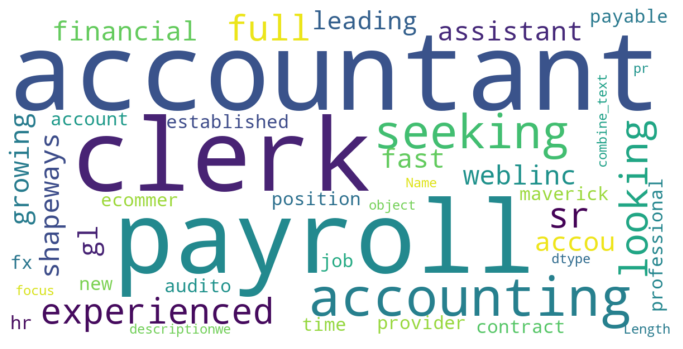

In [41]:
# Generate WordCloud for acct_cleaned dataset.
show_wordcloud(acct_cleaned['combine_text'])

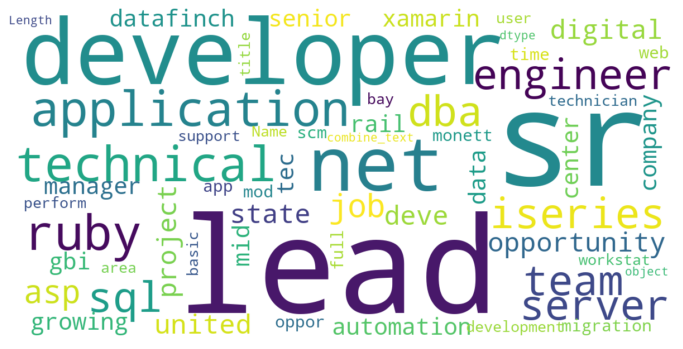

In [42]:
# Generate WordCloud for it_cleaned dataset.
show_wordcloud(it_cleaned['combine_text'])

Based on the wordcloud, we are able to tell that keywords such as accountant, clerk, payroll, financial appear more prominate than others for the Accounting industry. As for Information Technology, we are seeing developer, application, lead, net, technical, ruby are appearing more.\
However, we need to know in detail the keywords that are appearing either more by frequencies or by weight so that it will help us to determine the which features we want to engineer later during the pre-processing.

Using `CountVectorizer` to look at the words that appear the most based on the number of times appearing in the document.

In [43]:
# Instantiate CountVectorizer
vectorizer = CountVectorizer(stop_words = 'english')

# Fit and transform datasets
acct_cvec = vectorizer.fit_transform(acct_cleaned['combine_text'])

# Convert the total word count into DataFrame
acct_cvec_df = pd.DataFrame(acct_cvec.todense(), columns=vectorizer.get_feature_names())

# Check out the head of the Dataframe
acct_cvec_df.head()

,00,000,08840,0f9315db6d4d95df29896ed19097c6509188e110bb52fe281743f28b62e0277f,0in,0pt,10,100,1099,1099assist,...,writes,writing,writingprioritizes,written,year,yearly,yearsof,yes,york,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [44]:
# find out how many times each word appear in combine_text by creating a 'Total' row at the end of the dataframe:
acct_cvec_df.loc['Total',:]= acct_cvec_df.sum(axis=0)
acct_cvec_df.loc['Total',:].sort_values(ascending=False)

# Convert it to a DataFrame
acct_cvec_df_count = pd.DataFrame(acct_cvec_df.loc['Total',:].sort_values(ascending=False))
acct_cvec_df_count.head()

,Total
accounting,321.0
financial,195.0
experience,186.0
account,161.0
company,156.0


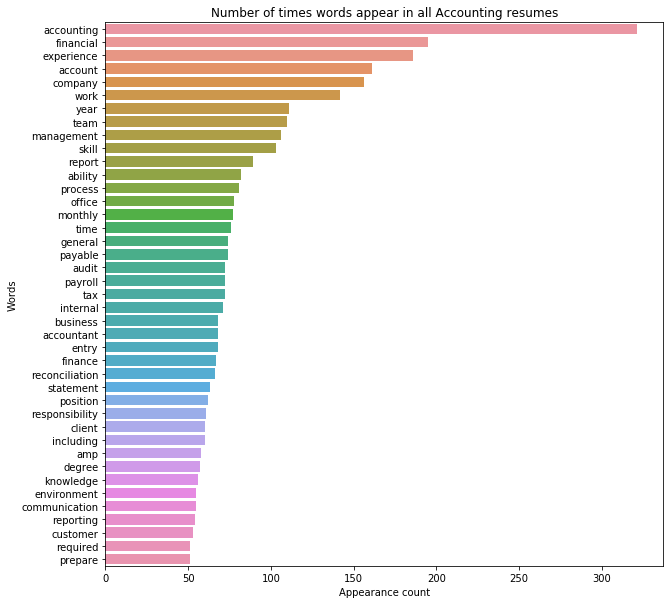

In [45]:
# Reset index
acct_cvec_df_count.reset_index(inplace=True)

# Sort counts
acct_cvec_df_count = acct_cvec_df_count[acct_cvec_df_count.Total > 50]

# Plotting the above Dataframe to a bar chart
plt.figure(figsize=(10,10))
sns.barplot(x=acct_cvec_df_count.Total, y='index', data=acct_cvec_df_count, orient='h')
plt.title('Number of times words appear in all Accounting resumes')
plt.xlabel('Appearance count')
plt.ylabel('Words');

In [46]:
# Let's make the above the same for Information Technology dataset
# Fit and transform dataset
it_cvec = vectorizer.fit_transform(it_cleaned['combine_text'])

# Convert the total word count into DataFrame
it_cvec_df = pd.DataFrame(it_cvec.todense(), columns=vectorizer.get_feature_names())

# Check out the head of the Dataframe
it_cvec_df.head()

,00,000,0001pt,000bonus,000term,00592duration,00start,01a736d89d2f0b19de700923d2c312837e180465650804d0f84105352812bf9a,0681797611a8accba88eb2beb42b2d13699be006bb140e46533bf3d0fdfe99f9,06876565bdc6a6865eb9bdb08d1d53b2f5d340a3af9746f600a4963a7cea24b9,...,zeco,zen,zencart,zend,zeno,zenworks,zero,zimbra,zoomtext,zurb
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# find out how many times each word appear in combine_text by creating a 'Total' row at the end of the dataframe:
it_cvec_df.loc['Total',:]= it_cvec_df.sum(axis=0)
it_cvec_df.loc['Total',:].sort_values(ascending=False)

# Convert it to a DataFrame
it_cvec_df_count = pd.DataFrame(it_cvec_df.loc['Total',:].sort_values(ascending=False))
it_cvec_df_count.head()

,Total
experience,2656.0
work,1295.0
team,1229.0
development,1209.0
application,1063.0


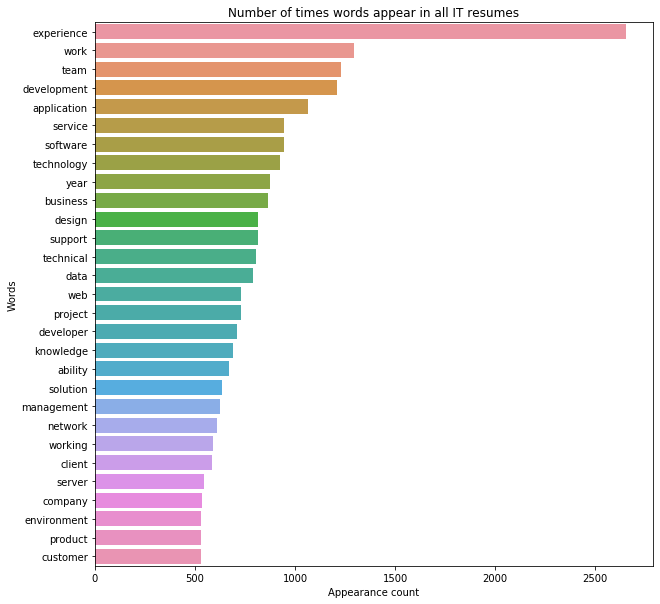

In [48]:
# Reset index
it_cvec_df_count.reset_index(inplace=True)

# Sort counts
it_cvec_df_count = it_cvec_df_count[it_cvec_df_count.Total > 500]

# Plotting the above Dataframe to a bar chart
plt.figure(figsize=(10,10))
sns.barplot(x=it_cvec_df_count.Total, y='index', data=it_cvec_df_count, orient='h')
plt.title('Number of times words appear in all IT resumes')
plt.xlabel('Appearance count')
plt.ylabel('Words');

Using `TfidfVectorizer` to look at the words based on the weight of the words.

In [49]:
# Instantiate CountVectorizer
tfvec = TfidfVectorizer(stop_words = 'english')

# Fit and transform datasets
acct_tfvec = tfvec.fit_transform(acct_cleaned['combine_text'])

# Convert the total word count into DataFrame
acct_tfvec_df = pd.DataFrame(acct_tfvec.todense(), columns=tfvec.get_feature_names())

# Check out the head of the Dataframe
acct_tfvec_df.head()

,00,000,08840,0f9315db6d4d95df29896ed19097c6509188e110bb52fe281743f28b62e0277f,0in,0pt,10,100,1099,1099assist,...,writes,writing,writingprioritizes,written,year,yearly,yearsof,yes,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.055166,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.053831,0.058330,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.051305,0.027796,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.032626,0.120447,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.039680,0.000000,0.0,0.0,0.0,0.0


In [50]:
# find out what is the weight of each word in combine_text by creating a 'Total' row at the end of the dataframe:
acct_tfvec_df.loc['Total',:]= acct_tfvec_df.sum(axis=0)
acct_tfvec_df.loc['Total',:].sort_values(ascending=False)

# Convert it to a DataFrame
acct_tfvec_df_count = pd.DataFrame(acct_tfvec_df.loc['Total',:].sort_values(ascending=False))
acct_tfvec_df_count.head()

,Total
accounting,7.095425
financial,5.212465
account,4.799433
experience,4.304363
company,3.925253


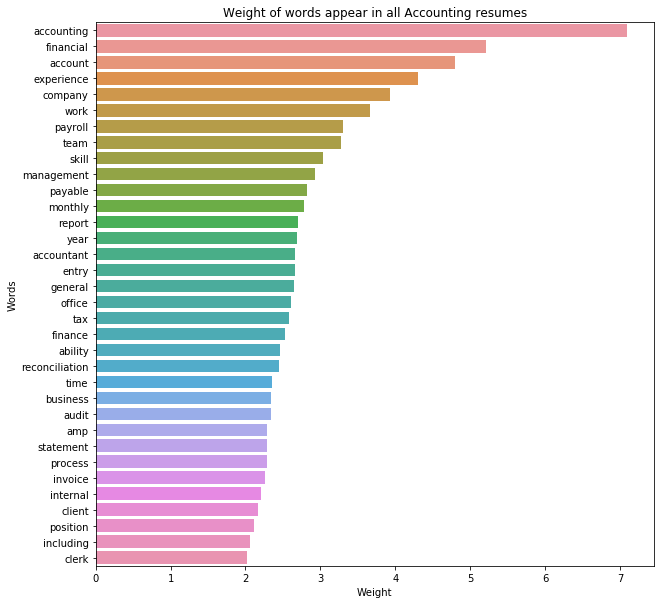

In [51]:
# Reset index
acct_tfvec_df_count.reset_index(inplace=True)

# Sort counts
acct_tfvec_df_count = acct_tfvec_df_count[acct_tfvec_df_count.Total > 2]

# Plotting the above Dataframe to a bar chart
plt.figure(figsize=(10,10))
sns.barplot(x=acct_tfvec_df_count.Total, y='index', data=acct_tfvec_df_count, orient='h')
plt.title('Weight of words appear in all Accounting resumes')
plt.xlabel('Weight')
plt.ylabel('Words');

In [52]:
# Let's make the above the same for Information Technology dataset
# Fit and transform datasets
it_tfvec = tfvec.fit_transform(it_cleaned['combine_text'])

# Convert the total word count into DataFrame
it_tfvec_df = pd.DataFrame(it_tfvec.todense(), columns=tfvec.get_feature_names())

# Check out the head of the Dataframe
it_tfvec_df.head()

,00,000,0001pt,000bonus,000term,00592duration,00start,01a736d89d2f0b19de700923d2c312837e180465650804d0f84105352812bf9a,0681797611a8accba88eb2beb42b2d13699be006bb140e46533bf3d0fdfe99f9,06876565bdc6a6865eb9bdb08d1d53b2f5d340a3af9746f600a4963a7cea24b9,...,zeco,zen,zencart,zend,zeno,zenworks,zero,zimbra,zoomtext,zurb
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.119506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.062356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# find out what is the weight of each word in combine_text by creating a 'Total' row at the end of the dataframe:
it_tfvec_df.loc['Total',:]= it_tfvec_df.sum(axis=0)
it_tfvec_df.loc['Total',:].sort_values(ascending=False)

# Convert it to a DataFrame
it_tfvec_df_count = pd.DataFrame(it_tfvec_df.loc['Total',:].sort_values(ascending=False))
it_tfvec_df_count.head()

,Total
experience,44.393632
development,27.257498
application,24.813519
work,24.659397
software,24.338031


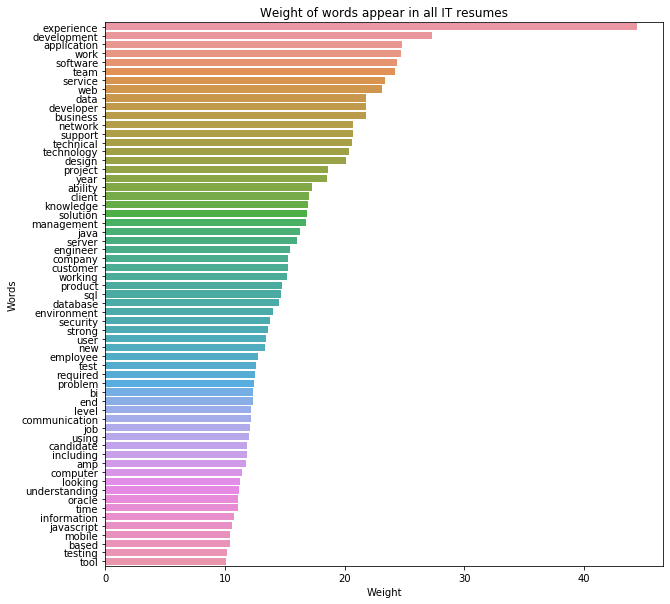

In [54]:
# Reset index
it_tfvec_df_count.reset_index(inplace=True)

# Sort counts
it_tfvec_df_count = it_tfvec_df_count[it_tfvec_df_count.Total > 10]

# Plotting the above Dataframe to a bar chart
plt.figure(figsize=(10,10))
sns.barplot(x=it_tfvec_df_count.Total, y='index', data=it_tfvec_df_count, orient='h')
plt.title('Weight of words appear in all IT resumes')
plt.xlabel('Weight')
plt.ylabel('Words');

In [56]:
# Saving a copy of the cleaned dataset for pre-processing and modeling
jobs.to_csv('./datasets/job_ads.csv', index=False)